In [14]:
import requests

url = 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/paul_graham/paul_graham_essay.txt'
filename = 'pg_essay.txt'

response = requests.get(url)
if response.status_code == 200:
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"File '{filename}' downloaded successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")


File 'pg_essay.txt' downloaded successfully.


In [15]:
import os
import openai
from llama_index.llms.openai import OpenAI
from dotenv import load_dotenv
load_dotenv('myenv/.env')
a=os.environ.get('OPENAI_API_KEY')
openai.api_key=a


In [16]:
with open('examples_files/pg_essay.txt') as file:
    essay = file.read()

In [17]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', essay)
print (f"{len(single_sentences_list)} senteneces were found")

745 senteneces were found


In [18]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': '\n\nWhat I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming.',
  'index': 0},
 {'sentence': "I didn't write essays.", 'index': 1},
 {'sentence': 'I wrote what beginning writers were supposed to write then, and probably still are: short stories.',
  'index': 2}]

`Great, now that we have our sentences, I want to combine the sentence before and after so that we reduce noise and capture more of the relationships between sequential sentences.`

In [19]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [20]:
sentences[:3]

[{'sentence': '\n\nWhat I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming.',
  'index': 0,
  'combined_sentence': "\n\nWhat I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming. I didn't write essays."},
 {'sentence': "I didn't write essays.",
  'index': 1,
  'combined_sentence': "\n\nWhat I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming. I didn't write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories."},
 {'sentence': 'I wrote what beginning writers were supposed to write then, and probably still are: short stories.',
  'index': 2,
  'combined_sentence': "I didn't write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful."}]

`Now I want to get embeddings for the combined sentences, so we can get the distances between the groups of 3 and find breakpoints. I'll use OpenAI's embeddings for this.`

In [21]:
from langchain_openai import OpenAIEmbeddings
oaiembeds = OpenAIEmbeddings()

In [22]:
embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

In [24]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

Great, now we're getting to the cool part, let's check out the cosine distances between sequential embedding pairs to see where the break points are. We'll add 'distance_to_next' as another key

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [30]:
distances, sentences = calculate_cosine_distances(sentences)

In [31]:
distances[:3]

[0.01574204911900401, 0.15846680670101376, 0.05284261691810188]

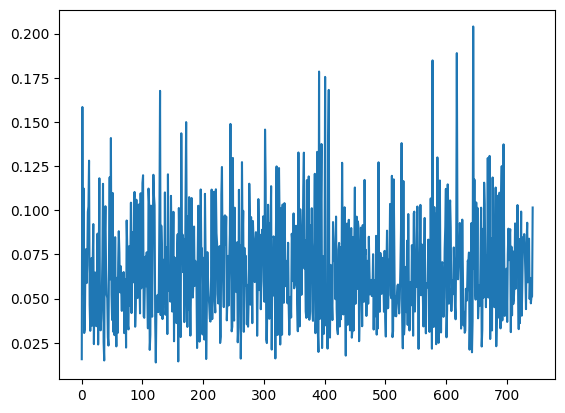

In [32]:
import matplotlib.pyplot as plt

plt.plot(distances);

### `There are many ways to chunk up the essay based off these distances, but I'm going to consider any distance above the 95th percentile of distances as a break point. This is the only parameter we'll need to config.`

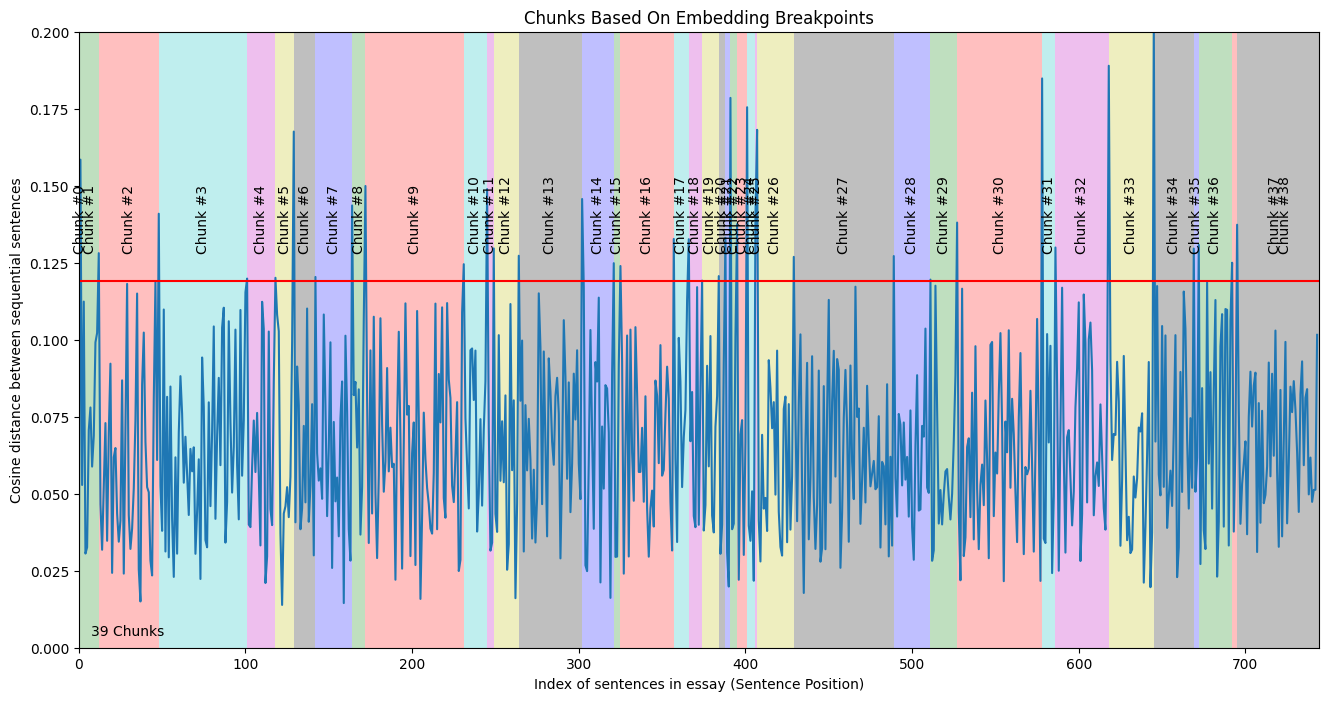

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(16, 8))  # Make the figure larger

# Your plotting code
plt.plot(distances)

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-')

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks")

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()


In [40]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

Great now let's manually inspect a few to make sure they look ok.

In [41]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
What I Worked On

February 2021

Before college the two main things I worked on, outside of school, were writing and programming. I didn't write essays.
...
What I Worked On

February 2021

Before college the two main things I worked on, outside of school, were writing and programming. I didn't write essays.


Chunk #1
I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagin
...
on to load the program into memory and run it. The result would ordinarily be to print something on the spectacularly loud printer. I was puzzled by the 1401. I couldn't figure out what to do with it.


